In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd

from rpy2.robjects import r

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R -o counts -o cells -o batch

suppressMessages(library(splatter))

params <- newSplatParams()

params <- setParam(params, "nGenes", 2000)
params <- setParam(params, "batchCells", c(1000, 1000, 2000))
params <- setParam(params, "batch.facLoc", 0.3)
params <- setParam(params, "batch.facScale", 0.3)
params <- setParam(params, "group.prob", c(1/4, 1/4, 1/4, 1/4))

sim <- splatSimulate(params, method="groups", verbose=FALSE)

counts <- data.frame(counts(sim))
cells <- colData(sim)[,"Group"]
batch <- colData(sim)[,"Batch"]

In [5]:
counts = np.array(counts)
meta = pd.DataFrame({'cells': cells, 'batch': batch} , dtype="str", index = range(0, len(cells)))

In [6]:
adata = ad.AnnData(X = counts.T, obs = meta)
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)

Transforming to str index.


... storing 'cells' as categorical
... storing 'batch' as categorical


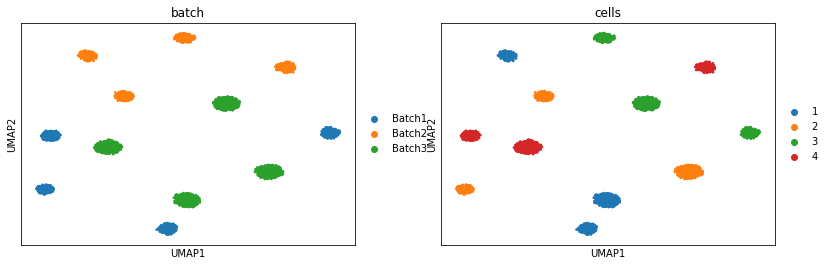

In [7]:
sc.pl.umap(adata,color=['batch','cells'])

In [8]:
from bbtnn import tnn

In [9]:
adata = adata[np.random.choice(adata.obs_names, adata.shape[0], replace = False)]

In [8]:
from bbtnn.tnn import *

In [9]:
ds1 = adata[adata.obs["batch"] == "0"].obsm["X_pca"]
ds2 = adata[adata.obs["batch"] == "1"].obsm["X_pca"]

In [16]:
def build_annoy_index(X, path, ntrees=50, build_index_on_disk=True, verbose=1):
    """ Build a standalone annoy index.
    :param array X: numpy array with shape (n_samples, n_features)
    :param str path: The filepath of a trained annoy index file
        saved on disk.
    :param int ntrees: The number of random projections trees built by Annoy to
        approximate KNN. The more trees the higher the memory usage, but the
        better the accuracy of results.
    :param bool build_index_on_disk: Whether to build the annoy index directly
        on disk. Building on disk should allow for bigger datasets to be indexed,
        but may cause issues. If None, on-disk building will be enabled for Linux, 
        but not Windows due to issues on Windows.
    :param int verbose: Controls the volume of logging output the model
        produces when training. When set to 0, silences outputs, when above 0
        will print outputs.
    """

    index = AnnoyIndex(X.shape[1], metric='euclidean')
    if build_index_on_disk:
        index.on_disk_build(path)

    if issparse(X):
        for i in tqdm(range(X.shape[0]), disable=verbose < 1):
            v = X[i].toarray()[0]
            index.add_item(i, v)
    else:
        for i in tqdm(range(X.shape[0]), disable=verbose < 1):
            v = X[i]
            index.add_item(i, v)
    
    try:
        index.build(ntrees)
    except Exception:
        msg = ("Error building Annoy Index. Passing on_disk_build=False"
                " may solve the issue, especially on Windows.")
        raise IndexBuildingError(msg)
    else:
        if not build_index_on_disk:
            index.save(path)
        return index


def extract_knn(X, index_filepath, k=150, search_k=-1, verbose=1):
    """ Starts multiple processes to retrieve nearest neighbours using
        an Annoy Index in parallel """

    n_dims = X.shape[1]

    chunk_size = X.shape[0] // cpu_count()
    remainder = (X.shape[0] % cpu_count()) > 0
    process_pool = []
    results_queue = Queue()

    # Split up the indices and assign processes for each chunk
    i = 0
    while (i + chunk_size) <= X.shape[0]:
        process_pool.append(KNN_Worker(X, index_filepath, k, search_k, n_dims,
                                       (i, i+chunk_size), results_queue))
        i += chunk_size
    if remainder:
        process_pool.append(KNN_Worker(X, index_filepath, k, search_k, n_dims,
                                       (i, X.shape[0]), results_queue))

    try:
        for process in process_pool:
            process.start()

        # Read from queue constantly to prevent it from becoming full
        with tqdm(total=X.shape[0], disable=verbose < 1) as pbar:
            neighbour_list = []
            neighbour_list_length = len(neighbour_list)
            while any(process.is_alive() for process in process_pool):
                while not results_queue.empty():
                    neighbour_list.append(results_queue.get())
                progress = len(neighbour_list) - neighbour_list_length
                pbar.update(progress)
                neighbour_list_length = len(neighbour_list)
                time.sleep(0.1)

            while not results_queue.empty():
                neighbour_list.append(results_queue.get())

        neighbour_list = sorted(neighbour_list, key=attrgetter('row_index'))
        neighbour_list = list(map(attrgetter('neighbour_list'), neighbour_list))

        return np.array(neighbour_list)
    
    except:
        print('Halting KNN retrieval and cleaning up')
        for process in process_pool:
            process.terminate()
        raise


IndexNeighbours = namedtuple('IndexNeighbours', 'row_index neighbour_list')


class KNN_Worker(Process):
    """
    Upon construction, this worker process loads an annoy index from disk.
    When started, the neighbours of the data-points specified by `data_indices`
    will be retrieved from the index according to the provided parameters
    and stored in the 'results_queue'.
    `data_indices` is a tuple of integers denoting the start and end range of
    indices to retrieve.
    """
    def __init__(self, X, index_filepath, k, search_k, n_dims,
                 data_indices, results_queue):
        self.index_filepath = index_filepath
        self.k = k
        self.X = X
        self.n_dims = n_dims
        self.search_k = search_k
        self.data_indices = data_indices
        self.results_queue = results_queue
        super(KNN_Worker, self).__init__()

    def run(self):
        try:
            index = AnnoyIndex(self.n_dims, metric='euclidean')
            index.load(self.index_filepath)
            for i in range(self.data_indices[0], self.data_indices[1]):
                neighbour_indexes = index.get_nns_by_vector(self.X[i,:]
                    , self.k, search_k=self.search_k, include_distances=False)
                neighbour_indexes = np.array(neighbour_indexes,
                                                dtype=np.uint32)
                self.results_queue.put(
                    IndexNeighbours(row_index=i,
                                    neighbour_list=neighbour_indexes))
        except Exception as e:
            self.exception = e
        finally:
            self.results_queue.close()


class IndexBuildingError(OSError):
    pass

In [32]:
def calculate_mnns(adata, batch_name = "batch", knn = 20):
    
    batch_indices = []
    for i in adata.obs[batch_name].unique():
        batch_indices.append(np.where(adata.obs[batch_name] == i))

    matches = []
    for i in list(itertools.combinations(range(len(batch_indices)), 2)):
        print(i)
        ref = batch_indices[i[0]]
        new = batch_indices[i[1]]
        ds1 = adata[ref].obsm["X_pca"]
        ds2 = adata[new].obsm["X_pca"]
        names1 = adata[ref].obs_names
        names2 = adata[new].obs_names

        match1 = nn_approx(ds1, ds2, names1, names2, knn=knn)
        match2 = nn_approx(ds2, ds1, names2, names1, knn=knn)
        mutual = match1 & set([ (b, a) for a, b in match2 ])
        mutual = list(mutual)
        matches += mutual

    return(matches)

def nn_approx(ds1, ds2, names1 , names2, knn = 20, n_trees = 50):

    build_annoy_index(ds2, path='annoy2.index', ntrees = n_trees, build_index_on_disk=False)
    tmp = extract_knn(ds1, index_filepath='annoy2.index',  k = knn)

    match = set()
    for a, b in zip(range(ds1.shape[0]), tmp):
        for b_i in b:
            match.add((names1[a], names2[b_i]))

    return match

In [31]:
X = ds1
verbose = 2
index = AnnoyIndex(X.shape[1], metric='euclidean')
for i in range(X.shape[0]):
    v = X[i]
    index.add_item(i, v)

index.build(50)
index.save("test.index")
index

In [33]:
match_new = calculate_mnns(adata, batch_name = "batch", knn = 50)

(0, 1)


100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 167177.01it/s]


Halting KNN retrieval and cleaning up


AttributeError: 'NoneType' object has no attribute 'terminate'

In [11]:
%%time
model = tnn.TNN(k = 10, batch_size = 32, n_epochs_without_progress = 2, verbose = 2)
model.fit(X = adata, Y = None)
embedding = model.transform(X = adata)

calc mnns


100%|██████████████████████████████████████████████████████████████████████████| 3000/3000 [00:00<00:00, 123198.83it/s]


Halting KNN retrieval and cleaning up


AttributeError: 'NoneType' object has no attribute 'terminate'

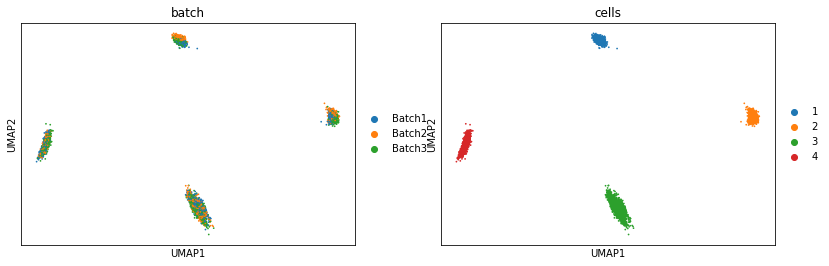

In [11]:
adata.obsm["X_umap"] = embedding
sc.pl.umap(adata, color = ["batch", "cells"])

In [12]:
bdata = adata[~((adata.obs["batch"] == "Batch1") & (adata.obs["cells"] =="4"))]
bdata = bdata[~((bdata.obs["batch"] == "Batch2") & (bdata.obs["cells"] =="4"))]

In [13]:
bdata

View of AnnData object with n_obs × n_vars = 8512 × 2000 
    obs: 'cells', 'batch', 'n_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'batch_colors', 'cells_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [22]:
sc.tl.pca(bdata)
sc.pp.neighbors(bdata, n_neighbors=10)
sc.tl.umap(bdata)

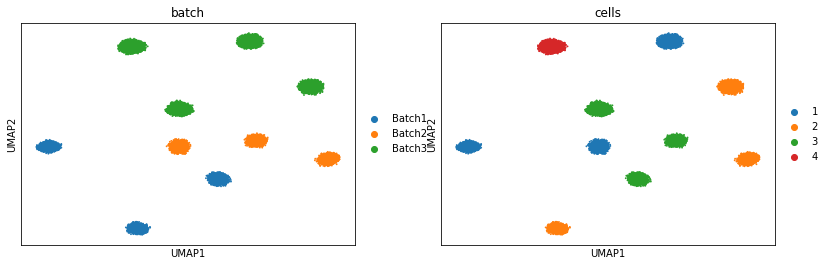

In [23]:
sc.pl.umap(bdata, color = ["batch", "cells"])

In [14]:
%%time
model = tnn.TNN(k = 1000, batch_size = 32, n_epochs_without_progress = 2, verbose = 2)
model.fit(X = bdata, Y = None)
embedding = model.transform(X = bdata)

calc mnns
[[0.         0.98088619 0.97058824]
 [0.         0.         0.98552036]
 [0.         0.         0.        ]]
sort mnns
calc knns
358
******Batches:[Batch2, Batch3, Batch1]
Categories (3, object): [Batch2, Batch3, Batch1]
******Total number of cells:8512
******Number of cells for MNN:8154
reformat
sort
Training neural network
Epoch 1/1000
266/266 - 4s - loss: 1.3579
Epoch 2/1000
266/266 - 2s - loss: 0.9517
Epoch 3/1000
266/266 - 2s - loss: 0.7038
Epoch 4/1000
266/266 - 2s - loss: 0.6261
Epoch 5/1000
266/266 - 2s - loss: 0.6074
Epoch 6/1000
266/266 - 2s - loss: 0.5785
Epoch 7/1000
266/266 - 2s - loss: 0.5564
Epoch 8/1000
266/266 - 2s - loss: 0.5504
Epoch 9/1000
266/266 - 2s - loss: 0.5449
Epoch 10/1000
266/266 - 2s - loss: 0.5534
Epoch 11/1000
266/266 - 2s - loss: 0.5256
Epoch 12/1000
266/266 - 2s - loss: 0.5354
Epoch 13/1000
266/266 - 2s - loss: 0.5253
Epoch 14/1000
266/266 - 2s - loss: 0.5269
Epoch 15/1000
266/266 - 2s - loss: 0.5300
8512/8512 - 0s
Wall time: 7min 4s


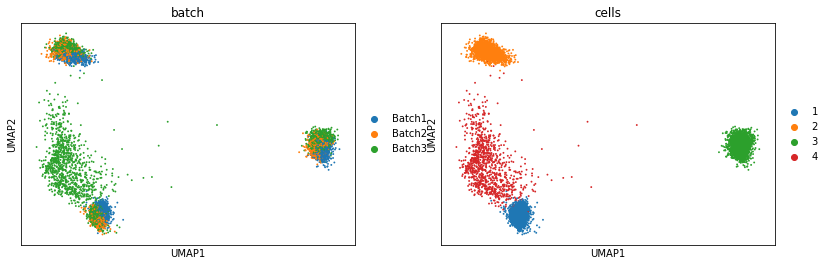

In [15]:
bdata.obsm["X_umap"] = embedding
sc.pl.umap(bdata, color = ["batch", "cells"])

In [25]:
from bbtnn import tnn_v2

In [45]:
%%time
model = tnn_v2.TNN(k = 25, batch_size = 32, n_epochs_without_progress = 2, verbose = 2)
model.fit(X = adata, batch_name = "batch", Y = None)
embedding = model.transform(X = adata)

Calculate MNN pairs
(0, 1)
(0, 2)
(1, 2)
Reformat MNN pairs
Calculate KNN neighborhood
******Batches:[Batch3, Batch1, Batch2]
Categories (3, object): [Batch3, Batch1, Batch2]
******Total number of cells:10000
******Number of cells for MNN:2692
******Number of cells for KNN:7308
Sort cells
Training neural network
Epoch 1/1000
313/313 - 3s - loss: 1.3886
Epoch 2/1000
313/313 - 1s - loss: 1.1445
Epoch 3/1000
313/313 - 1s - loss: 1.1232
Epoch 4/1000
313/313 - 1s - loss: 1.1018
Epoch 5/1000
313/313 - 1s - loss: 1.0858
Epoch 6/1000
313/313 - 1s - loss: 1.0791
Epoch 7/1000
313/313 - 1s - loss: 1.0713
Epoch 8/1000
313/313 - 1s - loss: 1.0638
Epoch 9/1000
313/313 - 1s - loss: 1.0574
Epoch 10/1000
313/313 - 1s - loss: 1.0495
Epoch 11/1000
313/313 - 1s - loss: 1.0453
Epoch 12/1000
313/313 - 1s - loss: 1.0418
Epoch 13/1000
313/313 - 1s - loss: 1.0399
Epoch 14/1000
313/313 - 1s - loss: 1.0370
Epoch 15/1000
313/313 - 1s - loss: 1.0320
Epoch 16/1000
313/313 - 1s - loss: 1.0285
Epoch 17/1000
313/313 -

In [16]:
adata.obsm["X_umap"] = embedding
sc.pl.umap(adata, color = ["batch", "cells"])

ValueError: Value passed for key 'X_umap' is of incorrect shape. Values of obsm must match dimensions (0,) of parent. Value had shape (8512, 2) while it should have had (10000,).

In [53]:
%%time
model = tnn_v2.TNN(k = 100, batch_size = 32, n_epochs_without_progress = 2, verbose = 2)
model.fit(X = bdata, batch_name = "batch", Y = None)
embedding = model.transform(X = bdata)

Calculate MNN pairs
(0, 1)
(0, 2)
(1, 2)
Reformat MNN pairs
Calculate KNN neighborhood
******Batches:[Batch3, Batch1, Batch2]
Categories (3, object): [Batch3, Batch1, Batch2]
******Total number of cells:8512
******Number of cells for MNN:4796
******Number of cells for KNN:3716
Sort cells
Training neural network
Epoch 1/1000
266/266 - 3s - loss: 1.3860
Epoch 2/1000
266/266 - 1s - loss: 1.1405
Epoch 3/1000
266/266 - 1s - loss: 1.1185
Epoch 4/1000
266/266 - 1s - loss: 1.1030
Epoch 5/1000
266/266 - 1s - loss: 1.0924
Epoch 6/1000
266/266 - 1s - loss: 1.0802
Epoch 7/1000
266/266 - 1s - loss: 1.0695
Epoch 8/1000
266/266 - 1s - loss: 1.0316
Epoch 9/1000
266/266 - 1s - loss: 0.9586
Epoch 10/1000
266/266 - 1s - loss: 0.9104
Epoch 11/1000
266/266 - 1s - loss: 0.8667
Epoch 12/1000
266/266 - 1s - loss: 0.8454
Epoch 13/1000
266/266 - 1s - loss: 0.8259
Epoch 14/1000
266/266 - 1s - loss: 0.8297
Epoch 15/1000
266/266 - 1s - loss: 0.8165
Epoch 16/1000
266/266 - 1s - loss: 0.7946
Epoch 17/1000
266/266 - 

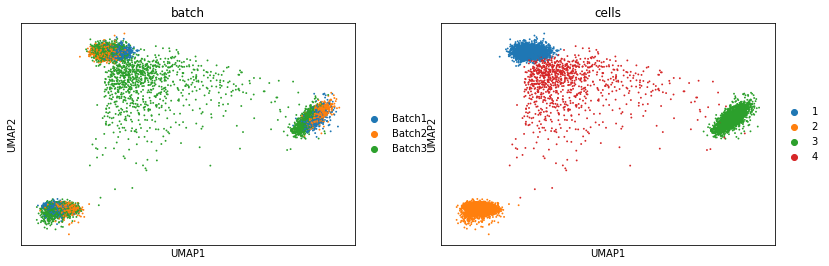

In [54]:
bdata.obsm["X_umap"] = embedding
sc.pl.umap(bdata, color = ["batch", "cells"])